<a href="https://colab.research.google.com/github/seansothey/CSC685/blob/master/Covid19_Machine_Learning_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](https://www.heywood.org/images/heyBanner/imgBanner/banner2.png)

Coronavirus (COVID-19) is a new virus that causes respiratory illness in people and is extremely contagious. Symptoms include fever, cough, shortness of breath, and diarrhea. 
The Pennsylvania COVID-19 guide (https://www.pa.gov/guides/responding-to-covid-19/) was created as a place for Pennsylvanians to quickly find the resources they need during the COVID-19 pandemic. Use this guide to learn about statewide efforts to contain the spread of the disease, what Stay at Home Orders mean, guidance for businesses, unemployment help and more. 

The guide is updated frequently with the latest efforts and announcements from government officials, so check back often for updates.
https://www.google.com/maps/d/u/0/viewer?mid=1lpLPPrltIuVkwFtXhoWdWEA4B1DvNmne&ll=41.03302245465488%2C-77.80500120579285&z=7

This experiment is conducted to contribute to our commnunities as for some helpful information, espeically on the real case numbers that keeps rising significantly. The dataset was downloaded from **Johns Hopkins Univerity** that's available in the link below. 
https://github.com/CSSEGISandData/COVID-19 .
The latest update for this dataset was April, 01 2020.

#Setup

In [64]:
# Common Import
import sklearn
import pandas as pd
import numpy as np

# Visaulization libraries
import plotly
plotly.io.renderers.default = 'colab'
import plotly.express as px
import plotly.graph_objects as go
import folium
from folium.plugins import HeatMap
from folium import plugins, FeatureGroup, LayerControl, Map, Marker
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt

# Set default plot size
plt.rcParams['figure.figsize'] = 10, 12

# Disable warnings
import warnings
warnings.filterwarnings('ignore')

# sklearn version > 0.20 is required 
sklearn.__version__
# Update sklearn -> !pip install -U scikit-learn

'0.22.2.post1'

#Load Data

In [0]:
covid19 = pd.read_csv('https://raw.githubusercontent.com/seansothey/CSC685/master/COVID-19%20Cases.csv') #with coordinate

In [0]:
covid19_ts = pd.read_csv('https://raw.githubusercontent.com/seansothey/CSC685/master/COVID-19%20global-time.csv') #with timeseries

In [67]:
covid19

,Province_State,Country,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key
0,South Carolina,US,4/1/2020 21:58,34.223334,-82.461707,4,0,0,0,"Abbeville, South Carolina, US"
1,Louisiana,US,4/1/2020 21:58,30.295065,-92.414197,47,1,0,0,"Acadia, Louisiana, US"
2,Virginia,US,4/1/2020 21:58,37.767072,-75.632346,7,0,0,0,"Accomack, Virginia, US"
3,Idaho,US,4/1/2020 21:58,43.452658,-116.241552,195,3,0,0,"Ada, Idaho, US"
4,Iowa,US,4/1/2020 21:58,41.330756,-94.471059,1,0,0,0,"Adair, Iowa, US"
...,...,...,...,...,...,...,...,...,...,...
2480,NaN,Venezuela,4/1/2020 21:58,6.423800,-66.589700,143,3,41,99,Venezuela
2481,NaN,Vietnam,4/1/2020 21:58,14.058324,108.277199,218,0,63,155,Vietnam
2482,NaN,West Bank and Gaza,4/1/2020 21:58,31.952200,35.233200,134,1,18,115,West Bank and Gaza
2483,NaN,Zambia,4/1/2020 21:58,-13.133897,27.849332,36,0,0,36,Zambia


##Data Queries

In [0]:
by_country = covid19.groupby('Country', as_index=0).sum()

In [0]:
top10 = by_country.sort_values('Confirmed', ascending=False).head(10)

In [0]:
top_deaths = by_country.sort_values('Deaths', ascending=False).head(10)

In [0]:
top_recovered = by_country.sort_values('Recovered', ascending=False).head(10)

In [0]:
usa = covid19.loc[covid19['Country']=='US']

In [0]:
state = usa.groupby('Province_State', as_index=0).sum()
state = state.sort_values('Confirmed', ascending=False)

#Analysing and Visualization

In [0]:
hmap = folium.Map(width=800,height=800,location=[30, -90.5], zoom_start=4)

In [100]:
hm_wide = HeatMap( list(zip(usa.Lat.values, usa.Long_.values)),
                     min_opacity=0.05,
                     radius=3, blur=1,
                     max_zoom=1)
hmap.add_child(hm_wide)
hmap

##Top 10 Confirmed Cases

In [76]:
fig = px.bar(top10, x='Country', y='Confirmed', color='Confirmed',
             labels={'Confirmed':'Confirmed_Cases'}, height=600, title='Top 10 Highest Confirmed Cases')
fig.show()

##Top 10 Deaths

In [77]:
fig = px.bar(top_deaths, x='Country', y='Deaths', color='Deaths', height=600, title='Top 10 Highest Deaths')
fig.show()

##Top 10 Recovered

In [78]:
fig = px.bar(top_recovered, x='Country', y='Recovered', color='Recovered', height=600, title='Top 10 Highest Recovered')
fig.show()

## The Curve for the last 30 days worldwide

In [79]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=covid19_ts['Date'], y=covid19_ts['Confirmed'],
                    mode='lines',
                    name='Confirmed_Case'))

fig.add_trace(go.Scatter(x=covid19_ts['Date'], y=covid19_ts['Deaths'],
                    mode='lines',
                    name='Death'))

fig.add_trace(go.Scatter(x=covid19_ts['Date'], y=covid19_ts['Recovered'],
                    mode='lines',
                    name='Recovered'))

# Edit the layout
fig.update_layout(title='The Curve Worldwide Last 30 Days',
                   xaxis_title='Daily',
                   yaxis_title='Number of Cases')

fig.show()


#Predict Confirmed Cases For Next 30 Days

In [0]:
from fbprophet import Prophet
fb = Prophet(interval_width=0.99)
fb2 = Prophet(interval_width=0.99)
fb3 = Prophet(interval_width=0.99)

In [81]:
confirmed = covid19_ts.groupby('Date').sum()['Confirmed'].reset_index()
confirmed.columns = ['ds', 'y']
confirmed['ds'] = pd.to_datetime(confirmed['ds'])
confirmed.tail()

,ds,y
66,2020-03-06,101801
67,2020-03-07,105847
68,2020-03-08,109821
69,2020-03-09,113590
70,2020-04-01,932605


Fit the model and make prediction for next 30 days

In [82]:
fb.fit(confirmed)
pred_confirmed = fb.make_future_dataframe(periods=30)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [83]:
pred_confirmed.tail()

,ds
96,2020-04-27
97,2020-04-28
98,2020-04-29
99,2020-04-30
100,2020-05-01


Forcast also the lower and upper limit of the prediction

In [84]:
confirmed_case = fb.predict(pred_confirmed)
confirmed_case[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
96,2020-04-27,2.041646e+06,1.697004e+06,2.343250e+06
97,2020-04-28,2.091075e+06,1.722895e+06,2.430426e+06
98,2020-04-29,2.137518e+06,1.749071e+06,2.475179e+06
99,2020-04-30,2.175354e+06,1.761788e+06,2.522818e+06
100,2020-05-01,2.222785e+06,1.781080e+06,2.599169e+06


##It can be seen that the number of confirmed case shall reach over 2 million in the begining of May

##The graph of prediction would be easier to digest

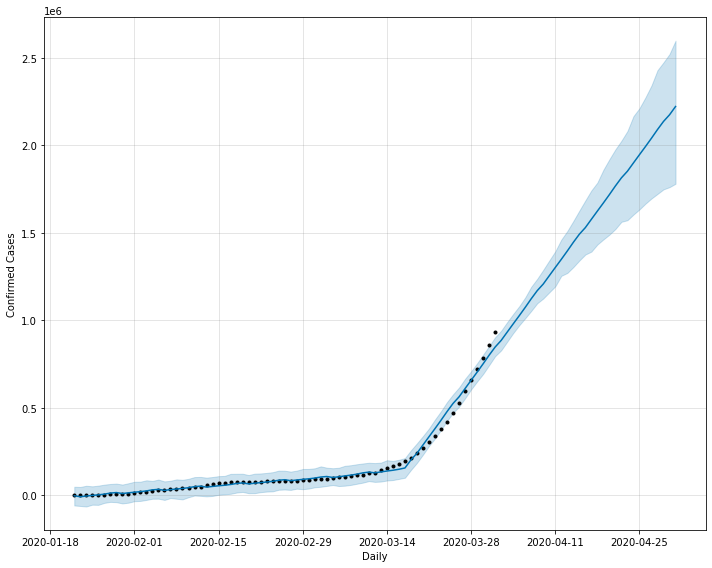

In [85]:
plot_confirmed = fb.plot(confirmed_case, plot_cap=True, xlabel='Daily', ylabel='Confirmed Cases', figsize=(10,8))

The number is scaled in 1/1000000

## Weekly Prediction

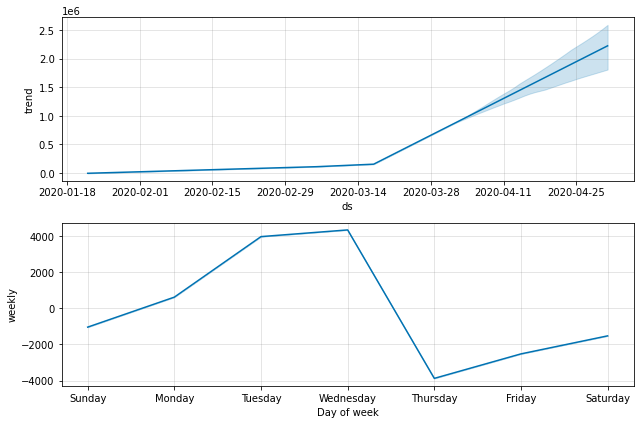

In [86]:
plot_confirmed_weekly = fb.plot_components(confirmed_case)

##Deaths Prediction

In [0]:
from fbprophet import Prophet
fb = Prophet(interval_width=0.99)

In [0]:
deaths = covid19_ts.groupby('Date').sum()['Deaths'].reset_index()
deaths.columns = ['ds', 'y']
deaths['ds'] = pd.to_datetime(deaths['ds'])

Fit the model and make prediction for next 30 days

In [89]:
fb.fit(deaths)
pred_deaths = fb.make_future_dataframe(periods=30)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [90]:
deaths_case = fb.predict(pred_deaths)
deaths_case[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
96,2020-04-27,100780.553606,83507.404330,117033.907838
97,2020-04-28,103369.824808,85254.721719,120749.382343
98,2020-04-29,105819.138315,86059.294402,125072.209497
99,2020-04-30,107450.520769,87535.732878,127745.252461
100,2020-05-01,109799.845789,88313.753442,129960.735945


##The number of death case could reach over 100,000 in the begining of May. 

## Graph prediction for deaths cases

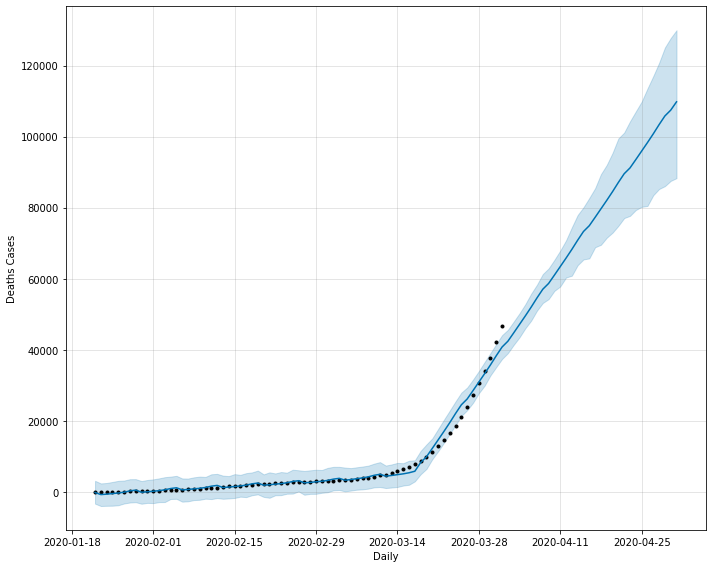

In [91]:
plot_deaths = fb.plot(deaths_case, plot_cap=True, xlabel='Daily', ylabel='Deaths Cases', figsize=(10,8))

##Weekly Graph

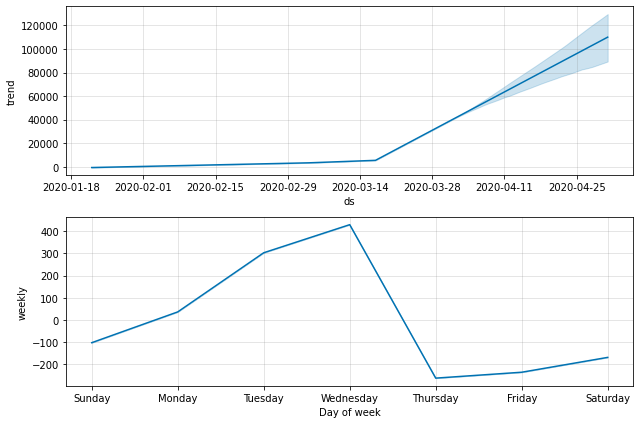

In [92]:
plot_deaths_weekly = fb.plot_components(deaths_case)

##Recovered Prediction

In [0]:
from fbprophet import Prophet
fb = Prophet(interval_width=0.99)

In [0]:
recovered = covid19_ts.groupby('Date').sum()['Recovered'].reset_index()
recovered.columns = ['ds', 'y']
recovered['ds'] = pd.to_datetime(recovered['ds'])

Fit the model and make prediction for next 30 days

In [95]:
fb.fit(recovered)
pred_recovered = fb.make_future_dataframe(periods=30)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [96]:
recovered_case = fb.predict(pred_recovered)
recovered_case[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
96,2020-04-27,320635.969286,281133.616076,361028.946895
97,2020-04-28,327656.817003,282184.445013,370261.297701
98,2020-04-29,334293.412260,289860.701424,381088.400681
99,2020-04-30,337457.244869,290056.345309,387813.712344
100,2020-05-01,343244.835389,294401.640615,391915.206303


##The number of recovered case would reach almost 400,000 in the begining of May

##Graph prediction for recovered cases

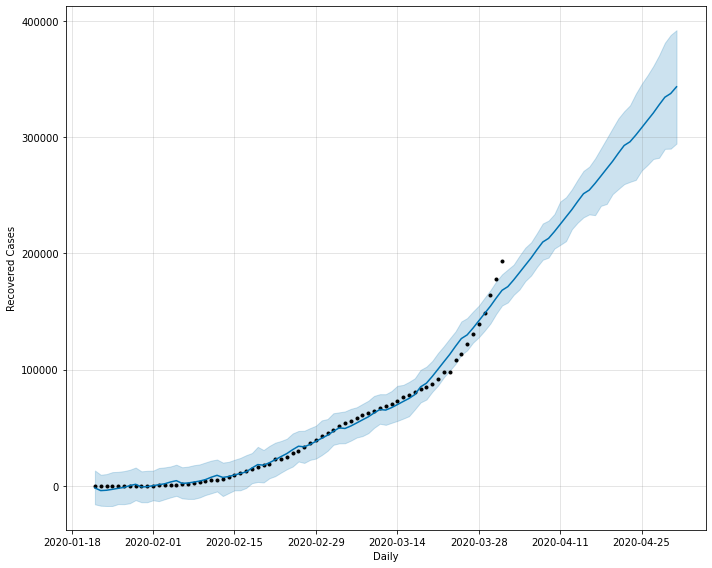

In [97]:
plot_recovered = fb.plot(recovered_case, plot_cap=True, xlabel='Daily', ylabel='Recovered Cases', figsize=(10,8))

##Weekly Graph

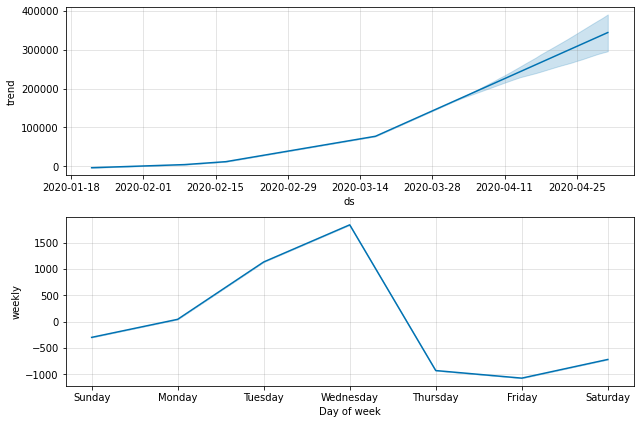

In [98]:
plot_recovered_weekly = fb.plot_components(recovered_case)

#Reminder:
There’s currently no vaccine to prevent coronavirus disease (COVID-19).  
You can protect yourself and help prevent spreading the virus to others if you:   

**Do**
1. Wash your hands regularly for 20 seconds, with soap and water or alcohol-based hand rub
2. Cover your nose and mouth with a disposable tissue or flexed elbow when you cough or sneeze
1. Avoid close contact (1 meter or 3 feet) with people who are unwell
2. Stay home and self-isolate from others in the household if you feel unwell

**Don't**


1. Touch your eyes, nose, or mouth if your hands are not clean
2. Go out if not necessary


![alt text](https://www.aljazeera.com/mritems/Images/2020/3/2/c51891264f4d403aaf7900fe98557af5_6.jpg)

![alt text](https://image.slidesharecdn.com/10funnyreasonswhyfacebookacquiredwhatsapp-140221091415-phpapp01/95/10-funny-reasons-why-facebook-acquired-whatsapp-2-638.jpg?cb=1393073870)




![alt text](https://2s7gjr373w3x22jf92z99mgm5w-wpengine.netdna-ssl.com/wp-content/uploads/2017/08/education_shutterstock_venimo.jpg)

***Autor: SEAN, SOTHEY***